We retrieve all NCAA tournament brackets dating back to 1985 since that is when the NCAA migrated to the 64-team format. 

In [7]:
'''
Input: A year in between 1985 and 2022 with the exception of 2020
Output: A (64 x 6) Dataframe where each row is a team and each column denotes a 
        round in the tournament. A '1' means the team won the matchup, and a '0'
        means the team lost that matchup. The DataFrame is formatted like a 
        bracket, so each matchup is between adjacent teams. For example,
        
        Seed:    Team Name:   Round_of_64:     Round_of_32: .... 
        1          TeamA          1                 1
        16         TeamB          0                 0
        8          TeamC          0                 0
        9          TeamD          1                 0
        ...

        In the Round of 64, TeamA plays TeamB and TeamA wins which is why
        TeamA has a 1 in the 'Round of 64' column and TeamB has a 0. Similarly,
        TeamD beats TeamC in the Round of 64. 

        In the Round of 32, TeamA will now play TeamD since they each won their 
        previous respective matchups. TeamA beats TeamD in the Round of 32, 
        so TeamA has a 1 in the 'Round of 32' column while TeamD has a 0.
'''

from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import random
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import random

def getBracket(year):
  year = str(year)
  source = requests.get('https://www.sports-reference.com/cbb/postseason/'+year+'-ncaa.html').text
  soup = BeautifulSoup(source, 'lxml')

  all_rounds = soup.find_all('div', class_ = 'round')

  order_of_regions = []
  for i in soup.find('div', {'id': 'brackets'}):
    if i.name == 'div':
      order_of_regions.append(i['id'])

  results = []

  for round in all_rounds:
    teams_in_round = round.find_all('div')
    counter = 0

    for matchup in teams_in_round:
      if counter%3 == 0:
        teams = matchup.find_all('div')
        for team in teams:
          info = team.a.text + " " + team.span.text
          results.append(info)
      counter+=1
  
  unique_teams = results[0:16] + results[31:47] + results[62:78] + results[93:109]


  # Region Winners are appended an extra time, so we must remove them in order 
  # for the frequency of their name to denote their (number of wins - 1) 

  results.pop(123)
  results.pop(92)
  results.pop(61)
  results.pop(30)

  games_won = dict()
  for team in results:
    if team not in games_won:
      games_won[team] = 0
    else:
      games_won[team] += 1

  df = pd.DataFrame(unique_teams, columns = ['Name+Seed']) 
  df.insert(1, 'R_64', 0)
  df.insert(2, 'R_32', 0)
  df.insert(3, 'R_16', 0)
  df.insert(4, 'R_8', 0)
  df.insert(5, 'R_4', 0)
  df.insert(6, 'R_2', 0)


  df['games_won'] = games_won.values()
  df.loc[df['games_won'] >= 1, 'R_64'] = 1
  df.loc[df['games_won'] >= 2, 'R_32'] = 1
  df.loc[df['games_won'] >= 3, 'R_16'] = 1
  df.loc[df['games_won'] >= 4, 'R_8'] = 1
  df.loc[df['games_won'] >= 5, 'R_4'] = 1
  df.loc[df['games_won'] >= 6, 'R_2'] = 1

  df.drop(columns = ['games_won'], inplace = True)

  df['region'] = [order_of_regions[0]]*16 + \
                  [order_of_regions[1]]*16 + \
                  [order_of_regions[2]]*16 + \
                  [order_of_regions[3]]*16  

  return df

Given a bracket, calculate the chalk index.

In [8]:
'''
Input: The bracket result of 'getBracket(year)' defined above
Output: The chalk index of the bracket
'''
def getChalkIndex(bracket):

  chalk_index = 0

  pred_64_seed = bracket[bracket['R_64'] == 1]['Name+Seed'].apply(lambda x: int(x.split(" ")[-1]))
  pred_64_chalk_seeds = np.array([1, 8, 5, 4, 6, 3, 7, 2, 
                                  1, 8, 5, 4, 6, 3, 7, 2,
                                  1, 8, 5, 4, 6, 3, 7, 2, 
                                  1, 8, 5, 4, 6, 3, 7, 2])
  chalk_index += sum(np.array(pred_64_seed) - pred_64_chalk_seeds)



  pred_32_seed = bracket[bracket['R_32'] == 1]['Name+Seed'].apply(lambda x: int(x.split(" ")[-1]))
  pred_32_chalk_seeds = np.array([1, 4, 3, 2, 
                                  1, 4, 3, 2, 
                                  1, 4, 3, 2, 
                                  1, 4, 3, 2])
  chalk_index += 2*(sum(np.array(pred_32_seed) - pred_32_chalk_seeds))



  pred_16_seed = bracket[bracket['R_16'] == 1]['Name+Seed'].apply(lambda x: int(x.split(" ")[-1]))
  pred_16_chalk_seeds = np.array([1, 2, 
                                  1, 2, 
                                  1, 2, 
                                  1, 2])
  chalk_index += 4*(sum(np.array(pred_16_seed) - pred_16_chalk_seeds))


  pred_8_seed = bracket[bracket['R_8'] == 1]['Name+Seed'].apply(lambda x: int(x.split(" ")[-1]))
  pred_8_chalk_seeds = np.array([1,  
                                  1, 
                                  1, 
                                  1])
  chalk_index += 8*(sum(np.array(pred_8_seed) - pred_8_chalk_seeds))


  pred_4_seed = bracket[bracket['R_4'] == 1]['Name+Seed'].apply(lambda x: int(x.split(" ")[-1]))
  pred_4_chalk_seeds = np.array([1,  
                                  1])
  chalk_index += 16*(sum(np.array(pred_4_seed) - pred_4_chalk_seeds))


  pred_2_seed = bracket[bracket['R_2'] == 1]['Name+Seed'].apply(lambda x: int(x.split(" ")[-1]))
  pred_2_chalk_seeds = np.array([1])
  chalk_index += 32*(sum(np.array(pred_2_seed) - pred_2_chalk_seeds))


  return chalk_index

In [ ]:
all_chalk_indexes = []

for year in range(1985, 2017):
  if year == 2020:
    continue
  curr = getChalkIndex(getBracket(year))
  all_chalk_indexes.append(curr)
  print("{}:{}".format(year, curr))

In [ ]:
class Team():
  def __init__(self, seed, region, stats):
    self.seed = seed
    self.region = region
    self.stats = stats

In [ ]:
class BracketNode():
  def __init__(self, choices = None, left = None, right = None, expected_winner = None, predicted_winner = None, bins = None):
    self.choices = choices
    self.left = left
    self.right = right
    self.expected_winner = expected_winner
    self.predicted_winner = predicted_winner

    self.parent = None
    self.bins = bins

    self.all_matchups = None

    if not self.choices and self.left and self.right:
      self.choices = self.left.choices + self.right.choices

    if len(self.choices) == 2:
      self.feedforward_choices = choices
    else:
      self.feedforward_choices = []

    for team in self.choices:
      if self.expected_winner == None:
        self.expected_winner = team
      else:
        if team.seed < self.expected_winner.seed:
          self.expected_winner = team

    if not self.bins:
    
      bins = dict()
      carryover = 0
      all_preds = []
      for team in self.choices:
        pred = model.predict_proba(np.array(team.stats[1:]).reshape(1,-1))
        all_preds.append(pred[0][1])

      pred_sum = sum(all_preds)

      for i in range(len(self.choices)):
        bins[(carryover, carryover + all_preds[i]/pred_sum)] = self.choices[i]
        carryover += all_preds[i]/pred_sum

      self.bins = bins
    

  def pick_winner(self):
    if not self.predicted_winner:
      self.predicted_winner = random.choice(self.choices)
    return self.predicted_winner 


  def pick_LR_winner(self):

    if not self.predicted_winner:

      gen_number = random.uniform(0, 1)

      for key, team in self.bins.items():
        first, second = key
        if gen_number >= first and gen_number <= second:
          self.predicted_winner = team
          return self.predicted_winner

  def pick_stochastic_winner(self,p_best_team_wins):
    if not self.predicted_winner:
      gen_number = random.uniform(0, 1)

      # pick lowest seed
      if gen_number < p_best_team_wins:
        for team in self.choices:
          if self.predicted_winner == None:
            self.predicted_winner = team
          else:
            if team.seed < self.predicted_winner.seed:
              self.predicted_winner = team
      else:
        self.predicted_winner = random.choice(self.choices)
    return self.predicted_winner



  def chalk_index(self):
    number_of_round = int(math.log2(len(self.choices)))
    return abs(self.predicted_winner.seed - self.expected_winner.seed)*2**(number_of_round-1)

  def prune(self):
    if not self.predicted_winner:
      raise Exception("Error in BracketNode.prune: No winner has been determined yet")
    if not self.left or not self.right:
      return
    if self.predicted_winner in self.left.choices:
      self.left.predicted_winner = self.predicted_winner
    elif self.predicted_winner in self.right.choices:
      self.right.predicted_winner = self.predicted_winner
  
  def reset_winner(self):
    self.predicted_winner = None

  def copy(self):
    new = BracketNode(self.choices, self.left, self.right, self.expected_winner, self.predicted_winner, self.bins)
    return new
  
  def set_parent(self, node):
    self.parent = node

  def add_feedforward_choice(self, team):
    self.feedforward_choices.append(team)

  def clear_feedforward_choices(self):
    if len(self.choices) == 2:
      self.feedforward_choices = self.choices
    else:
      self.feedforward_choices = []

In [ ]:

'''
Input: A tournament year with a cleaned dataset
Output: A reference to the root winner node

'''

#@title Make Bracket

def make_bracket(year):
  df = clean_data(get_data(year, year+1))

  df.drop(columns = ['R_AdjO', 'R_AdjD', 
                    'R_AdjT', 'R_Luck', 
                     'R_AdjEM1', 'R_OppO',  'R_OppD', 
                     'R_AdjEM2',"W_64","W_32",
                     "W_16","W_8","W_4","W_2"], inplace = True)


  df.replace(np.nan,0, inplace = True)



  TL_1  = Team(1,  "TL", df.iloc[0].to_list())
  TL_16 = Team(16, "TL", df.iloc[1].to_list())
  TL_8  = Team(8,  "TL", df.iloc[2].to_list())
  TL_9  = Team(9,  "TL", df.iloc[3].to_list())
  TL_5  = Team(5,  "TL", df.iloc[4].to_list())
  TL_12 = Team(12, "TL", df.iloc[5].to_list())
  TL_4  = Team(4,  "TL", df.iloc[6].to_list())
  TL_13 = Team(13, "TL", df.iloc[7].to_list())
  TL_6  = Team(6,  "TL", df.iloc[8].to_list())
  TL_11 = Team(11, "TL", df.iloc[9].to_list())
  TL_3  = Team(3,  "TL", df.iloc[10].to_list())
  TL_14 = Team(14, "TL", df.iloc[11].to_list())
  TL_7  = Team(7,  "TL", df.iloc[12].to_list())
  TL_10 = Team(10, "TL", df.iloc[13].to_list())
  TL_2  = Team(2,  "TL", df.iloc[14].to_list())
  TL_15 = Team(15, "TL", df.iloc[15].to_list())


  BL_1  = Team(1,  "BL", df.iloc[16].to_list())
  BL_16 = Team(16, "BL", df.iloc[17].to_list())
  BL_8  = Team(8,  "BL", df.iloc[18].to_list())
  BL_9  = Team(9,  "BL", df.iloc[19].to_list())
  BL_5  = Team(5,  "BL", df.iloc[20].to_list())
  BL_12 = Team(12, "BL", df.iloc[21].to_list())
  BL_4  = Team(4,  "BL", df.iloc[22].to_list())
  BL_13 = Team(13, "BL", df.iloc[23].to_list())
  BL_6  = Team(6,  "BL", df.iloc[24].to_list())
  BL_11 = Team(11, "BL", df.iloc[25].to_list())
  BL_3  = Team(3,  "BL", df.iloc[26].to_list())
  BL_14 = Team(14, "BL", df.iloc[27].to_list())
  BL_7  = Team(7,  "BL", df.iloc[28].to_list())
  BL_10 = Team(10, "BL", df.iloc[29].to_list())
  BL_2  = Team(2,  "BL", df.iloc[30].to_list())
  BL_15 = Team(15, "BL", df.iloc[31].to_list())



  TR_1  = Team(1,  "TR", df.iloc[32].to_list())
  TR_16 = Team(16, "TR", df.iloc[33].to_list())
  TR_8  = Team(8,  "TR", df.iloc[34].to_list())
  TR_9  = Team(9,  "TR", df.iloc[35].to_list())
  TR_5  = Team(5,  "TR", df.iloc[36].to_list())
  TR_12 = Team(12, "TR", df.iloc[37].to_list())
  TR_4  = Team(4,  "TR", df.iloc[38].to_list())
  TR_13 = Team(13, "TR", df.iloc[39].to_list())
  TR_6  = Team(6,  "TR", df.iloc[40].to_list())
  TR_11 = Team(11, "TR", df.iloc[41].to_list())
  TR_3  = Team(3,  "TR", df.iloc[42].to_list())
  TR_14 = Team(14, "TR", df.iloc[43].to_list())
  TR_7  = Team(7,  "TR", df.iloc[44].to_list())
  TR_10 = Team(10, "TR", df.iloc[45].to_list())
  TR_2  = Team(2,  "TR", df.iloc[46].to_list())
  TR_15 = Team(15, "TR", df.iloc[47].to_list())


  BR_1  = Team(1,  "BR", df.iloc[48].to_list())
  BR_16 = Team(16, "BR", df.iloc[49].to_list())
  BR_8  = Team(8,  "BR", df.iloc[50].to_list())
  BR_9  = Team(9,  "BR", df.iloc[51].to_list())
  BR_5  = Team(5,  "BR", df.iloc[52].to_list())
  BR_12 = Team(12, "BR", df.iloc[53].to_list())
  BR_4  = Team(4,  "BR", df.iloc[54].to_list())
  BR_13 = Team(13, "BR", df.iloc[55].to_list())
  BR_6  = Team(6,  "BR", df.iloc[56].to_list())
  BR_11 = Team(11, "BR", df.iloc[57].to_list())
  BR_3  = Team(3,  "BR", df.iloc[58].to_list())
  BR_14 = Team(14, "BR", df.iloc[59].to_list())
  BR_7  = Team(7,  "BR", df.iloc[60].to_list())
  BR_10 = Team(10, "BR", df.iloc[61].to_list())
  BR_2  = Team(2,  "BR", df.iloc[62].to_list())
  BR_15 = Team(15, "BR", df.iloc[63].to_list())

  #####################################
  TL_matchup1 = BracketNode(choices = [TL_1, TL_16])
  TL_matchup2 = BracketNode(choices = [TL_8, TL_9])
  TL_matchup3 = BracketNode(choices = [TL_5, TL_12])
  TL_matchup4 = BracketNode(choices = [TL_4, TL_13])
  TL_matchup5 = BracketNode(choices = [TL_6, TL_11])
  TL_matchup6 = BracketNode(choices = [TL_3, TL_14])
  TL_matchup7 = BracketNode(choices = [TL_7, TL_10])
  TL_matchup8 = BracketNode(choices = [TL_2, TL_15])

  BL_matchup1 = BracketNode(choices = [BL_1, BL_16])
  BL_matchup2 = BracketNode(choices = [BL_8, BL_9])
  BL_matchup3 = BracketNode(choices = [BL_5, BL_12])
  BL_matchup4 = BracketNode(choices = [BL_4, BL_13])
  BL_matchup5 = BracketNode(choices = [BL_6, BL_11])
  BL_matchup6 = BracketNode(choices = [BL_3, BL_14])
  BL_matchup7 = BracketNode(choices = [BL_7, BL_10])
  BL_matchup8 = BracketNode(choices = [BL_2, BL_15])



  TR_matchup1 = BracketNode(choices = [TR_1, TR_16])
  TR_matchup2 = BracketNode(choices = [TR_8, TR_9])
  TR_matchup3 = BracketNode(choices = [TR_5, TR_12])
  TR_matchup4 = BracketNode(choices = [TR_4, TR_13])
  TR_matchup5 = BracketNode(choices = [TR_6, TR_11])
  TR_matchup6 = BracketNode(choices = [TR_3, TR_14])
  TR_matchup7 = BracketNode(choices = [TR_7, TR_10])
  TR_matchup8 = BracketNode(choices = [TR_2, TR_15])


  BR_matchup1 = BracketNode(choices = [BR_1, BR_16])
  BR_matchup2 = BracketNode(choices = [BR_8, BR_9])
  BR_matchup3 = BracketNode(choices = [BR_5, BR_12])
  BR_matchup4 = BracketNode(choices = [BR_4, BR_13])
  BR_matchup5 = BracketNode(choices = [BR_6, BR_11])
  BR_matchup6 = BracketNode(choices = [BR_3, BR_14])
  BR_matchup7 = BracketNode(choices = [BR_7, BR_10])
  BR_matchup8 = BracketNode(choices = [BR_2, BR_15])
  #####################################


  #####################################
  TL_r32_1 = BracketNode(left = TL_matchup1,
                              right = TL_matchup2)
  TL_r32_2 = BracketNode(left = TL_matchup3,
                              right = TL_matchup4)
  TL_r32_3 = BracketNode(left = TL_matchup5,
                              right = TL_matchup6)
  TL_r32_4 = BracketNode(left = TL_matchup7,
                              right = TL_matchup8)


  BL_r32_1 = BracketNode(left = BL_matchup1,
                              right = BL_matchup2)
  BL_r32_2 = BracketNode(left = BL_matchup3,
                              right = BL_matchup4)
  BL_r32_3 = BracketNode(left = BL_matchup5,
                              right = BL_matchup6)
  BL_r32_4 = BracketNode(left = BL_matchup7,
                              right = BL_matchup8)


  TR_r32_1 = BracketNode(left = TR_matchup1,
                              right = TR_matchup2)
  TR_r32_2 = BracketNode(left = TR_matchup3,
                              right = TR_matchup4)
  TR_r32_3 = BracketNode(left = TR_matchup5,
                              right = TR_matchup6)
  TR_r32_4 = BracketNode(left = TR_matchup7,
                              right = TR_matchup8)



  BR_r32_1 = BracketNode(left = BR_matchup1,
                              right = BR_matchup2)
  BR_r32_2 = BracketNode(left = BR_matchup3,
                              right = BR_matchup4)
  BR_r32_3 = BracketNode(left = BR_matchup5,
                              right = BR_matchup6)
  BR_r32_4 = BracketNode(left = BR_matchup7,
                              right = BR_matchup8)
  #####################################


  #####################################
  TL_r16_1 = BracketNode(left = TL_r32_1,
                              right = TL_r32_2)
  TL_r16_2 = BracketNode(left = TL_r32_3,
                              right = TL_r32_4)

  BL_r16_1 = BracketNode(left = BL_r32_1,
                              right = BL_r32_2)
  BL_r16_2 = BracketNode(left = BL_r32_3,
                              right = BL_r32_4)

  TR_r16_1 = BracketNode(left = TR_r32_1,
                              right = TR_r32_2)
  TR_r16_2 = BracketNode(left = TR_r32_3,
                              right = TR_r32_4)

  BR_r16_1 = BracketNode(left = BR_r32_1,
                              right = BR_r32_2)
  BR_r16_2 = BracketNode(left = BR_r32_3,
                              right = BR_r32_4)
  #####################################



  #####################################
  TL_r8_1 = BracketNode(left = TL_r16_1,
                              right = TL_r16_2)

  BL_r8_1 = BracketNode(left = BL_r16_1,
                              right = BL_r16_2)

  TR_r8_1 = BracketNode(left = TR_r16_1,
                              right = TR_r16_2)

  BR_r8_1 = BracketNode(left = BR_r16_1,
                              right = BR_r16_2)
  #####################################


  #####################################
  ff_1 = BracketNode(left = TL_r8_1,
                              right = BL_r8_1)

  ff_2 = BracketNode(left = TR_r8_1,
                              right = BR_r8_1)
  #####################################



  #####################################
  winner = BracketNode(left = ff_1,
                              right = ff_2)
  #####################################

  ff_1.set_parent(winner)
  ff_2.set_parent(winner)

  TL_r8_1.set_parent(ff_1)
  BL_r8_1.set_parent(ff_1)
  TR_r8_1.set_parent(ff_2)
  BR_r8_1.set_parent(ff_2)

  TL_r16_1.set_parent(TL_r8_1)
  TL_r16_2.set_parent(TL_r8_1)
  BL_r16_1.set_parent(BL_r8_1)
  BL_r16_2.set_parent(BL_r8_1)
  TR_r16_1.set_parent(TR_r8_1)
  TR_r16_2.set_parent(TR_r8_1)
  BR_r16_1.set_parent(BR_r8_1)
  BR_r16_2.set_parent(BR_r8_1)

  TL_r32_1.set_parent(TL_r16_1)
  TL_r32_2.set_parent(TL_r16_1)
  TL_r32_3.set_parent(TL_r16_2)
  TL_r32_4.set_parent(TL_r16_2)
  BL_r32_1.set_parent(BL_r16_1)
  BL_r32_2.set_parent(BL_r16_1)
  BL_r32_3.set_parent(BL_r16_2)
  BL_r32_4.set_parent(BL_r16_2)
  TR_r32_1.set_parent(TR_r16_1)
  TR_r32_2.set_parent(TR_r16_1)
  TR_r32_3.set_parent(TR_r16_2)
  TR_r32_4.set_parent(TR_r16_2)
  BR_r32_1.set_parent(BR_r16_1)
  BR_r32_2.set_parent(BR_r16_1)
  BR_r32_3.set_parent(BR_r16_2)
  BR_r32_4.set_parent(BR_r16_2)


  TL_matchup1.set_parent(TL_r32_1)
  TL_matchup2.set_parent(TL_r32_1)
  TL_matchup3.set_parent(TL_r32_2)
  TL_matchup4.set_parent(TL_r32_2)
  TL_matchup5.set_parent(TL_r32_3)
  TL_matchup6.set_parent(TL_r32_3)
  TL_matchup7.set_parent(TL_r32_4)
  TL_matchup8.set_parent(TL_r32_4)
  BL_matchup1.set_parent(BL_r32_1)
  BL_matchup2.set_parent(BL_r32_1)
  BL_matchup3.set_parent(BL_r32_2)
  BL_matchup4.set_parent(BL_r32_2)
  BL_matchup5.set_parent(BL_r32_3)
  BL_matchup6.set_parent(BL_r32_3)
  BL_matchup7.set_parent(BL_r32_4)
  BL_matchup8.set_parent(BL_r32_4)
  TR_matchup1.set_parent(TR_r32_1)
  TR_matchup2.set_parent(TR_r32_1)
  TR_matchup3.set_parent(TR_r32_2)
  TR_matchup4.set_parent(TR_r32_2)
  TR_matchup5.set_parent(TR_r32_3)
  TR_matchup6.set_parent(TR_r32_3)
  TR_matchup7.set_parent(TR_r32_4)
  TR_matchup8.set_parent(TR_r32_4)
  BR_matchup1.set_parent(BR_r32_1)
  BR_matchup2.set_parent(BR_r32_1)
  BR_matchup3.set_parent(BR_r32_2)
  BR_matchup4.set_parent(BR_r32_2)
  BR_matchup5.set_parent(BR_r32_3)
  BR_matchup6.set_parent(BR_r32_3)
  BR_matchup7.set_parent(BR_r32_4)
  BR_matchup8.set_parent(BR_r32_4)
  ###################################
  all_TL = [TL_1, TL_16, TL_8, TL_9, TL_5, TL_12, TL_4, TL_13, TL_6, TL_11, 
            TL_3, TL_14, TL_7, TL_10, TL_2, TL_15]
  all_BL = [BL_1, BL_16, BL_8, BL_9, BL_5, BL_12, BL_4, BL_13, BL_6, BL_11, 
            BL_3, BL_14, BL_7, BL_10, BL_2, BL_15]
  all_TR = [TR_1, TR_16, TR_8, TR_9, TR_5, TR_12, TR_4, TR_13, TR_6, TR_11, 
            TR_3, TR_14, TR_7, TR_10, TR_2, TR_15]
  all_BR = [BR_1, BR_16, BR_8, BR_9, BR_5, BR_12, BR_4, BR_13, BR_6, BR_11, 
            BR_3, BR_14, BR_7, BR_10, BR_2, BR_15]

  winner.all_matchups = [TL_matchup1,
                              TL_matchup2, TL_matchup3,
                              TL_matchup4, TL_matchup5,
                              TL_matchup6, TL_matchup7,
                              TL_matchup8, BL_matchup1,
                              BL_matchup2, BL_matchup3,
                              BL_matchup4, BL_matchup5,
                              BL_matchup6, BL_matchup7,
                              BL_matchup8, TR_matchup1,
                              TR_matchup2,  TR_matchup3,
                              TR_matchup4,  TR_matchup5,
                              TR_matchup6,  TR_matchup7,
                              TR_matchup8,  BR_matchup1,
                              BR_matchup2, BR_matchup3,
                              BR_matchup4, BR_matchup5,
                              BR_matchup6, BR_matchup7,
                              BR_matchup8]

  return winner, all_TL, all_BL, all_TR, all_BR


In [ ]:
def simulation(winner, chalk_index_total):
  current_chalk_index = 0

  queue = [winner]
  storage = []
  while queue:
    current_round = queue.pop(0)
    if current_round.left:
      queue.append(current_round.left)
    if current_round.right:
      queue.append(current_round.right)
    current_round.pick_winner()
    current_round.prune()
    storage.append(current_round.copy())
    current_chalk_index += current_round.chalk_index()
    current_round.reset_winner()

    if current_chalk_index > chalk_index_total:
      return None
    
  if current_chalk_index == chalk_index_total:
    return storage
  return None


def logistic_regression_and_chalk(winner, chalk_index_total):
  current_chalk_index = 0

  queue = [winner]
  storage = []
  while queue:
    current_round = queue.pop(0)
    if current_round.left:
      queue.append(current_round.left)
    if current_round.right:
      queue.append(current_round.right)
    current_round.pick_LR_winner()
    current_round.prune()
    storage.append(current_round.copy())
    current_chalk_index += current_round.chalk_index()
    current_round.reset_winner()

    if current_chalk_index > chalk_index_total:
      return None
    
  if current_chalk_index == chalk_index_total:
    return storage
  return None


def logistic_regression(winner):

  queue = [winner]
  storage = []
  while queue:
    current_round = queue.pop(0)
    if current_round.left:
      queue.append(current_round.left)
    if current_round.right:
      queue.append(current_round.right)
    current_round.pick_LR_winner()
    current_round.prune()
    storage.append(current_round.copy())
    current_round.reset_winner()


  return storage

def best_stochastic(winner, p_best_team_wins):

  queue = [winner]
  storage = []
  while queue:
    current_round = queue.pop(0)
    if current_round.left:
      queue.append(current_round.left)
    if current_round.right:
      queue.append(current_round.right)
    current_round.pick_stochastic_winner(p_best_team_wins)
    current_round.prune()
    storage.append(current_round.copy())
    current_round.reset_winner()


  return storage

def best_stochastic_with_chalk(winner, chalk_index_total, p_best_team_wins):
  current_chalk_index = 0

  queue = [winner]
  storage = []
  while queue:
    current_round = queue.pop(0)
    if current_round.left:
      queue.append(current_round.left)
    if current_round.right:
      queue.append(current_round.right)
    current_round.pick_stochastic_winner(p_best_team_wins)
    current_round.prune()
    storage.append(current_round.copy())
    current_chalk_index += current_round.chalk_index()
    current_round.reset_winner()

    if current_chalk_index > chalk_index_total:
      return None
    
  if current_chalk_index == chalk_index_total:
    return storage
  return None



def old_logistic_regression(first_round_games):
  queue = first_round_games.copy()

  while queue:
    matchup = queue.pop(0)

    team1 = matchup.feedforward_choices[0]
    team2 = matchup.feedforward_choices[1]

    p_team1 = model.predict_proba(np.array(team1.stats[1:]).reshape(1,-1))
    p_team2 = model.predict_proba(np.array(team2.stats[1:]).reshape(1,-1))

    threshold = random.uniform(0, 1)

    sum_probs = p_team1[0][1] + p_team2[0][1]

    bucket1 = (0, p_team1[0][1]/sum_probs)
    bucket2 = (p_team1[0][1]/sum_probs, 1)

    
    if threshold >= bucket1[0] and threshold <= bucket1[1]:
      matchup.predicted_winner = team1
    else:
      matchup.predicted_winner = team2
  
    if matchup.parent:
      matchup.parent.add_feedforward_choice(matchup.predicted_winner)

      if matchup.parent not in queue:
        queue.append(matchup.parent)

  storage = []
  output_queue = [matchup]
  while output_queue:
    current_team = output_queue.pop(0)
    if current_team.left:
      output_queue.append(current_team.left)
    if current_team.right:
      output_queue.append(current_team.right)
    storage.append(current_team)
    current_team.clear_feedforward_choices()
  return storage




def random_pick(winner):
  
  queue = [winner]
  storage = []
  while queue:
    current_round = queue.pop(0)
    if current_round.left:
      queue.append(current_round.left)
    if current_round.right:
      queue.append(current_round.right)
    current_round.pick_winner()
    current_round.prune()
    storage.append(current_round.copy())
    current_round.reset_winner()

  return storage




def best_team(first_round_games, percentage_of_underdog):
  
  queue = first_round_games.copy().copy()
  while queue:
    matchup = queue.pop(0)

    team1 = matchup.feedforward_choices[0]
    team2 = matchup.feedforward_choices[1]

    threshold = random.uniform(0, 1) > percentage_of_underdog

    if (team1.seed < team2.seed) and threshold:
        matchup.predicted_winner = team1
    elif (team1.seed < team2.seed) and not threshold:
        matchup.predicted_winner = team2
    elif (team1.seed >= team2.seed) and threshold:
        matchup.predicted_winner = team2
    elif (team1.seed >= team2.seed) and not threshold:
        matchup.predicted_winner = team1    
    if matchup.parent:
      matchup.parent.add_feedforward_choice(matchup.predicted_winner)

      if matchup.parent not in queue:
        queue.append(matchup.parent)

  storage = []
  output_queue = [matchup]
  while output_queue:
    current_team = output_queue.pop(0)
    if current_team.left:
      output_queue.append(current_team.left)
    if current_team.right:
      output_queue.append(current_team.right)
    storage.append(current_team)
    current_team.clear_feedforward_choices()
  return storage



def best_team_w_C(first_round_games, percentage_of_underdog, chalk_index_total):
  current_chalk_index = 0

  queue = first_round_games.copy().copy()
  while queue:
    matchup = queue.pop(0)

    team1 = matchup.feedforward_choices[0]
    team2 = matchup.feedforward_choices[1]

    threshold = random.uniform(0, 1) > percentage_of_underdog

    if (team1.seed < team2.seed) and threshold:
        matchup.predicted_winner = team1
    elif (team1.seed < team2.seed) and not threshold:
        matchup.predicted_winner = team2
    elif (team1.seed >= team2.seed) and threshold:
        matchup.predicted_winner = team2
    elif (team1.seed >= team2.seed) and not threshold:
        matchup.predicted_winner = team1    
    if matchup.parent:
      matchup.parent.add_feedforward_choice(matchup.predicted_winner)

      if matchup.parent not in queue:
        queue.append(matchup.parent)

    current_chalk_index += matchup.chalk_index()


    if current_chalk_index > chalk_index_total:
      return None
    
  if current_chalk_index != chalk_index_total:
    return None


  storage = []
  output_queue = [matchup]
  while output_queue:
    current_team = output_queue.pop(0)
    if current_team.left:
      output_queue.append(current_team.left)
    if current_team.right:
      output_queue.append(current_team.right)
    storage.append(current_team)
    current_team.clear_feedforward_choices()
  return storage

In [ ]:
def run_simulations(n, bracket, actual = None, method = None, threshold = None):
  all_performance = []
  ESPN_scores = []

  for iteration in range(n):
    sampled_chalk_index = random.choice(all_chalk_indexes) 
    while True:
      if method == 'chalk_index':
        current_sim_result = simulation(bracket, sampled_chalk_index)
      elif method == 'logistic_regression_with_chalk':
        current_sim_result = logistic_regression_and_chalk(bracket, sampled_chalk_index)
      elif method == 'random_pick':
        current_sim_result = random_pick(bracket)
      elif method == 'stochastic_best':
        current_sim_result = best_stochastic(bracket, threshold)
      elif method == 'stochastic_best_w_C':
        current_sim_result = best_stochastic_with_chalk(bracket, sampled_chalk_index, threshold)
      elif method == 'logistic_regression':
        current_sim_result = logistic_regression(bracket)
      else:
        raise Exception("{} is not a valid simulation method".format(method))
      if current_sim_result:
        break
      
    ESPN_scoring = 0

    current_sim_result.reverse()

    for index, element in enumerate(current_sim_result):
      if element.predicted_winner.seed == actual[index].seed and element.predicted_winner.region == actual[index].region :

        if index >=0 and index<=31:
          ESPN_scoring += 1
        elif index > 31 and index <= 47:
          ESPN_scoring += 2
        elif index > 47 and index <= 55:
          ESPN_scoring += 4
        elif index > 55 and index <= 59:
          ESPN_scoring += 8
        elif index > 59 and index <= 61:
          ESPN_scoring += 16
        elif index == 62:
          ESPN_scoring += 32         
        else:
          raise Exception("Bracket too large")

    ESPN_scores.append(ESPN_scoring)

    

  return ESPN_scores

In [ ]:
def get_test_year(year):

    bracket = getBracket(year)

    winner, all_TL, all_BL, all_TR, all_BR = make_bracket(year)

    

    year_region_lookup = {2016: {'south': 'TL', 'west': 'BL', 'east': 'TR', 'midwest': 'BR'}, 
                          2017: {'south': 'BR', 'west': 'BL', 'east': 'TL', 'midwest': 'TR'}, 
                          2018: {'south': 'TL', 'west': 'BL', 'east': 'TR', 'midwest': 'BR'},
                          2019: {'south': 'TR', 'west': 'BL', 'east': 'TL', 'midwest': 'BR'},
                          2021: {'south': 'TR', 'west': 'TL', 'east': 'BL', 'midwest': 'BR'}, 
                          2022: {'south': 'TR', 'west': 'TL', 'east': 'BL', 'midwest': 'BR'}, 
                      }
    
    bracket.loc[bracket['region'] == 'east', 'quadrant'] = year_region_lookup[year]['east']
    bracket.loc[bracket['region'] == 'west', 'quadrant'] = year_region_lookup[year]['west']
    bracket.loc[bracket['region'] == 'midwest', 'quadrant'] = year_region_lookup[year]['midwest']   
    bracket.loc[bracket['region'] == 'south', 'quadrant'] = year_region_lookup[year]['south']

    inorder_bracket = pd.DataFrame()
    inorder_bracket = inorder_bracket.append(bracket.loc[bracket['quadrant'] == 'TL'])
    inorder_bracket = inorder_bracket.append(bracket.loc[bracket['quadrant'] == 'BL'])
    inorder_bracket = inorder_bracket.append(bracket.loc[bracket['quadrant'] == 'TR'])
    inorder_bracket = inorder_bracket.append(bracket.loc[bracket['quadrant'] == 'BR'])

    inorder_bracket.reset_index(inplace = True)
    inorder_bracket.drop(columns = ['index'], inplace = True)

    reference_to_node = all_TL + all_BL + all_TR + all_BR


    results = []
    results += inorder_bracket.index[inorder_bracket['R_2'] == 1].to_list()
    results += inorder_bracket.index[inorder_bracket['R_4'] == 1].to_list()
    results += inorder_bracket.index[inorder_bracket['R_8'] == 1].to_list()
    results += inorder_bracket.index[inorder_bracket['R_16'] == 1].to_list()
    results += inorder_bracket.index[inorder_bracket['R_32'] == 1].to_list()
    results += inorder_bracket.index[inorder_bracket['R_64'] == 1].to_list()

    references = []
    for r in results:
      references.append(reference_to_node[r])
    
    references.reverse()

    return references

In [ ]:
def test(year):

  print(year)

  winner, all_TL, all_BL, all_TR, all_BR = make_bracket(year)

  random.seed(1)
  all_LR = run_simulations(100, winner, get_test_year(year), 'logistic_regression')
  print("Logistic Regression: ", all_LR)

  random.seed(1)
  all_LR_w_C = run_simulations(100, winner, get_test_year(year), 'logistic_regression_with_chalk')
  print("Logistic Regression with Chalk: ", all_LR_w_C)

  random.seed(1)
  all_best_team = run_simulations(100, winner, get_test_year(year), 'stochastic_best', (763/1024))
  print("Stochastic Best: ", all_best_team)


  random.seed(1)
  all_best_team_w_C = run_simulations(100, winner, get_test_year(year), 'stochastic_best_w_C', (763/1024))
  print("Stochastic Best with Chalk: ", all_best_team_w_C)


  random.seed(1)
  random_picks = run_simulations(100, winner, get_test_year(year), 'random_pick')
  print("Random Pick: ", random_picks)

  random.seed(1)
  chalk_index = run_simulations(100, winner, get_test_year(year), 'chalk_index')
  print("Random Pick with Chalk: ", chalk_index)


  return all_LR, all_LR_w_C, all_best_team, all_best_team_w_C, random_picks, chalk_index

In [ ]:
def get_data(year1, year2):
  # Generating Training Set of Years (year1 to year2-1)  inclusive
  df = pd.DataFrame()
  for i in range(year1, year2):
    df = df.append(pd.read_csv(str(i) + ".csv"))
  df.reset_index(inplace = True)
  df.drop(columns = ['index'], inplace = True)
  return df
display(get_data(2011, 2016).head())

,Name+Seed,Pure Text,Rank,Conference,W-L,AP_Preseason_Rank,First_Four_Team,AQ/Conference_Winner,AdjEM,AdjO,...,OppD,R_OppD,AdjEM2,R_AdjEM2,W_64,W_32,W_16,W_8,W_4,W_2
0,Ohio St. 1,Ohio St.,1,B10,32-2,3,0,1,0.9804,124.7,...,98.0,40,0.4185,243,1,1,0,0,0,0
1,Texas San Antonio 16,Texas San Antonio,218,Slnd,20-13,Not Ranked,1,1,0.3472,100.4,...,104.7,300,0.4033,259,0,0,0,0,0,0
2,George Mason 8,George Mason,27,CAA,26-6,Not Ranked,0,0,0.8964,113.1,...,102.1,164,0.5125,158,1,0,0,0,0,0
3,Villanova 9,Villanova,26,BE,21-11,Not Ranked,0,0,0.8969,114.6,...,97.2,14,0.4843,182,0,0,0,0,0,0
4,West Virginia 5,West Virginia,19,BE,21-11,Not Ranked,0,0,0.9200,114.4,...,96.5,5,0.7238,21,1,0,0,0,0,0


Our data has some strings (such as Team Name and Conference) and other non-numerical columns such as Win-Loss Record. Some metrics are also bounded between 0 and 1 while others can max at around 300. We take these dataset characteristics into account while cleaning our data

In [ ]:
def clean_data(bracket):

  # Converting a W-L record to a percentage (i.e. a 3-1 record is 0.75)
  def winning_percentage(record):
    seperate = record.split('-')
    wins = seperate[0]
    losses = seperate[1]
    wins,losses = float(wins),float(losses)
    pctg = wins/(wins+losses)
    return pctg

  # separating the seed number
  def seeds(name_and_seed):
    match = re.findall(r'\d+',name_and_seed,flags=0)
    return int(match[0])

  # The best 25 teams in the preseason is ranked while the others are given
  # the 'Not Ranked' tag. I assign a value of '26' to all the 'Not Ranked' 
  # teams since rankings range from 1-25
  def preseason_rank(rank):
      if rank == "Not Ranked":
        rank = 26
      return int(rank)
      
  # one-hot encoding all conferences
  def conferences(df):

    all_conf = ['A10',	'ACC',	'AE',	'ASun',	'B10',	'B12',	'BE',	'BSky',	'BSth',	'BW',	
              'CAA',	'CUSA',	'Horz',	'Ivy',	'MAAC',	'MAC',	'MEAC',	'MVC',	'MWC',	
              'NEC',	'OVC',	'P10',	'Pat',	'SC',	'SEC',	'Slnd',	'Sum',	'WAC',	'WCC',	
              'P12',	'SB',	'SWAC',	'Amer']
    df = df.join(pd.get_dummies(df['Conference']))

    for c in all_conf:
      if c not in df.columns:
        df[c] = [0]*len(df.index)
    
    return df

  # min-max normalization for each column
  def normalize_data(df):
    return (df-df.min())/(df.max()-df.min())
  

  bracket = conferences(bracket)
  
  bracket['WinPercent'] = bracket['W-L'].apply(winning_percentage)
  bracket['Seeds'] = bracket['Name+Seed'].apply(seeds)
  bracket['AP_Preseason_Rank'] = bracket['AP_Preseason_Rank'].apply(preseason_rank)
  

  bracket.drop(columns = ['Conference','W-L', 'Name+Seed'], inplace=True)
  placeholder = bracket['Pure Text']
  bracket = normalize_data(bracket.drop(columns = ['Pure Text']))
  bracket.insert(0, 'Pure Text', placeholder)

  return bracket

In [ ]:
def train_model(df):
  # The Ranking Features are directly correlated with their magnitudes,
  # so we remove them since logistic regression is sensitive to correlated
  # features
  df.drop(columns = ['R_AdjO', 'R_AdjD', 
                    'R_AdjT', 'R_Luck', 
                     'R_AdjEM1', 'R_OppO',  'R_OppD', 
                     'R_AdjEM2'], inplace = True)


  og = curr = df

  curr.reset_index(inplace = True)
  curr.drop(columns = ['index'], inplace = True)

  target = [list(og['W_64'])]

  flattened_target = [item for sublist in target for item in sublist] 

  curr.insert(20,"TargetWin",flattened_target)

  X = curr.drop(columns = ['Pure Text', 'TargetWin', 'W_64', 'W_32', 'W_16', 'W_8', 'W_4', 'W_2'])
  y = curr['TargetWin'] 

  model = LogisticRegression()
  model.fit(X.values,y)

  return model, X


In [ ]:
display(clean_data(get_data(2011, 2017)))

,Pure Text,Rank,AP_Preseason_Rank,First_Four_Team,AQ/Conference_Winner,AdjEM,AdjO,R_AdjO,AdjD,R_AdjD,...,SB,SC,SEC,SWAC,Slnd,Sum,WAC,WCC,WinPercent,Seeds
0,Ohio St.,0.000000,0.08,0.0,1.0,1.000000,0.972299,0.000000,0.239130,0.023739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.900929,0.000000
1,Texas San Antonio,0.812734,1.00,1.0,1.0,0.108420,0.299169,0.598101,0.776398,0.727003,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.336523,1.000000
2,George Mason,0.097378,1.00,0.0,0.0,0.881723,0.650970,0.088608,0.394410,0.127596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.684211,0.466667
3,Villanova,0.093633,1.00,0.0,0.0,0.882427,0.692521,0.069620,0.434783,0.163205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.421053,0.533333
4,West Virginia,0.067416,1.00,0.0,0.0,0.914954,0.686981,0.072785,0.357143,0.091988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.421053,0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,Fresno St.,0.389513,1.00,0.0,1.0,0.548155,0.459834,0.389241,0.599379,0.293769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.554180,0.866667
380,Dayton,0.198502,1.00,0.0,0.0,0.718671,0.418283,0.503165,0.397516,0.038576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.631579,0.400000
381,Syracuse,0.149813,1.00,0.0,0.0,0.761616,0.548476,0.234177,0.478261,0.109792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.315789,0.600000
382,Michigan St.,0.007491,0.48,0.0,1.0,0.950155,0.878116,0.003165,0.428571,0.053412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.752322,0.066667


In [ ]:
model, features = train_model(clean_data(get_data(2011, 2017)))

In [ ]:
test(2017)

In [ ]:
'''
2017
Logistic Regression:  [54, 45, 126, 39, 58, 66, 45, 92, 40, 67, 44, 54, 37, 42, 36, 51, 46, 47, 93, 49, 40, 50, 48, 42, 57, 51, 25, 37, 43, 52, 48, 71, 50, 70, 50, 37, 65, 61, 45, 53, 93, 32, 121, 39, 61, 43, 39, 54, 41, 70, 40, 57, 42, 43, 43, 34, 36, 47, 66, 40, 60, 35, 28, 65, 41, 40, 53, 64, 45, 39, 75, 47, 32, 55, 37, 64, 51, 36, 47, 33, 33, 38, 55, 36, 66, 62, 35, 113, 44, 34, 48, 38, 44, 43, 54, 46, 37, 48, 47, 51]
Logistic Regression with Chalk:  [80, 91, 106, 39, 42, 132, 115, 43, 64, 49, 48, 74, 43, 48, 89, 57, 65, 59, 85, 46, 135, 49, 71, 133, 100, 59, 56, 68, 76, 130, 68, 50, 72, 99, 61, 53, 78, 51, 65, 72, 76, 41, 53, 99, 79, 58, 45, 67, 66, 35, 36, 51, 51, 76, 54, 79, 61, 41, 91, 62, 59, 110, 67, 76, 59, 81, 47, 61, 70, 39, 55, 83, 49, 53, 45, 91, 69, 51, 51, 83, 58, 46, 71, 54, 49, 82, 41, 58, 42, 39, 79, 122, 43, 91, 79, 85, 38, 45, 52, 67]
Stochastic Best:  [66, 78, 79, 66, 54, 68, 74, 74, 76, 89, 77, 61, 64, 60, 71, 84, 70, 74, 47, 44, 61, 81, 63, 76, 72, 65, 67, 121, 82, 72, 59, 76, 57, 57, 49, 48, 63, 75, 79, 77, 68, 78, 77, 43, 70, 75, 74, 65, 64, 75, 60, 73, 78, 63, 70, 52, 60, 75, 95, 62, 82, 69, 66, 63, 55, 62, 79, 78, 67, 59, 61, 69, 76, 62, 81, 62, 67, 79, 44, 76, 80, 75, 64, 52, 76, 79, 53, 78, 56, 65, 80, 60, 55, 71, 79, 53, 59, 77, 67, 76]
Stochastic Best with Chalk:  [72, 62, 73, 45, 74, 63, 84, 63, 56, 59, 77, 57, 61, 63, 64, 57, 52, 117, 59, 79, 61, 54, 72, 65, 55, 65, 64, 53, 65, 58, 50, 74, 70, 55, 73, 74, 55, 53, 75, 60, 65, 72, 56, 66, 60, 57, 62, 59, 63, 65, 50, 70, 53, 79, 65, 60, 82, 55, 56, 76, 69, 66, 67, 77, 56, 51, 54, 58, 52, 74, 72, 68, 76, 65, 79, 51, 62, 52, 57, 59, 57, 58, 64, 65, 57, 68, 68, 57, 61, 68, 76, 65, 76, 78, 64, 80, 59, 59, 66, 67]
Random Pick:  [51, 38, 15, 44, 32, 20, 16, 32, 58, 28, 46, 60, 26, 27, 25, 104, 32, 43, 38, 41, 17, 67, 16, 21, 31, 54, 39, 31, 51, 25, 25, 57, 28, 29, 25, 32, 37, 38, 18, 23, 32, 19, 24, 26, 34, 33, 24, 24, 28, 52, 43, 26, 29, 22, 37, 31, 39, 23, 29, 13, 21, 30, 14, 23, 28, 24, 21, 28, 50, 27, 32, 26, 23, 30, 43, 54, 29, 32, 11, 23, 32, 42, 42, 40, 35, 36, 32, 71, 41, 30, 23, 79, 33, 25, 18, 60, 77, 23, 35, 31]
Random Pick with Chalk:  [134, 60, 57, 133, 48, 82, 47, 101, 69, 75, 68, 113, 103, 37, 65, 78, 59, 101, 81, 111, 43, 39, 77, 111, 92, 49, 57, 38, 56, 72, 80, 32, 27, 39, 46, 59, 44, 60, 116, 73, 128, 81, 49, 47, 124, 83, 43, 61, 108, 44, 98, 74, 116, 57, 56, 59, 24, 105, 57, 117, 110, 77, 34, 68, 71, 38, 76, 127, 88, 101, 72, 60, 42, 149, 138, 70, 42, 49, 39, 67, 43, 58, 101, 88, 50, 99, 88, 85, 39, 43, 44, 59, 32, 100, 84, 65, 99, 45, 83, 61]

2018
Logistic Regression:  [32, 23, 27, 34, 76, 38, 47, 52, 55, 121, 36, 36, 27, 35, 46, 29, 68, 37, 64, 37, 44, 38, 38, 29, 58, 30, 38, 37, 21, 32, 33, 40, 34, 31, 30, 72, 26, 53, 39, 33, 37, 44, 57, 71, 57, 46, 36, 38, 40, 31, 65, 46, 41, 34, 50, 43, 51, 30, 49, 58, 51, 35, 25, 50, 39, 29, 51, 40, 36, 52, 39, 28, 36, 66, 34, 42, 42, 64, 51, 25, 50, 47, 46, 87, 35, 34, 40, 57, 88, 56, 38, 38, 59, 58, 19, 52, 30, 45, 43, 57]
Logistic Regression with Chalk:  [95, 53, 44, 66, 47, 79, 46, 47, 61, 29, 21, 42, 40, 62, 43, 49, 43, 108, 75, 51, 45, 47, 67, 97, 63, 45, 61, 57, 60, 35, 66, 62, 63, 46, 56, 34, 51, 106, 38, 53, 48, 83, 40, 38, 115, 60, 101, 111, 50, 46, 101, 95, 56, 54, 68, 42, 99, 63, 59, 59, 116, 46, 57, 44, 105, 44, 65, 55, 40, 56, 129, 89, 72, 64, 98, 34, 54, 58, 47, 51, 39, 44, 49, 26, 59, 42, 70, 55, 64, 68, 65, 45, 61, 33, 55, 58, 47, 101, 54, 91]
Stochastic Best:  [49, 57, 76, 77, 41, 53, 75, 75, 55, 82, 80, 40, 47, 75, 78, 79, 81, 49, 32, 51, 74, 82, 66, 81, 71, 66, 70, 62, 53, 81, 46, 109, 68, 44, 48, 77, 48, 92, 50, 80, 77, 85, 76, 64, 69, 76, 81, 76, 61, 72, 79, 74, 83, 50, 77, 63, 53, 74, 64, 41, 79, 76, 45, 44, 56, 79, 76, 81, 68, 66, 48, 78, 51, 71, 82, 69, 66, 80, 31, 77, 79, 80, 85, 55, 71, 80, 66, 77, 49, 80, 85, 67, 66, 68, 82, 66, 68, 50, 42, 81]
Stochastic Best with Chalk:  [77, 45, 50, 28, 79, 48, 57, 52, 57, 80, 80, 68, 60, 70, 55, 72, 55, 60, 62, 76, 42, 63, 53, 40, 62, 98, 43, 46, 62, 67, 51, 75, 73, 64, 52, 75, 34, 42, 56, 69, 52, 75, 61, 65, 79, 76, 69, 86, 64, 70, 63, 51, 60, 78, 70, 71, 49, 58, 59, 79, 70, 41, 72, 80, 47, 68, 73, 69, 47, 77, 69, 45, 39, 52, 54, 66, 67, 45, 38, 58, 70, 51, 63, 70, 78, 49, 51, 32, 46, 87, 83, 50, 79, 77, 55, 83, 48, 56, 79, 76]
Random Pick:  [36, 53, 34, 25, 29, 19, 25, 27, 25, 25, 33, 45, 23, 26, 88, 59, 37, 24, 27, 28, 32, 54, 19, 18, 36, 53, 26, 28, 34, 36, 16, 44, 35, 28, 18, 19, 30, 29, 41, 46, 27, 26, 39, 21, 53, 34, 41, 27, 27, 43, 34, 29, 20, 21, 30, 32, 34, 28, 28, 14, 22, 19, 35, 38, 31, 31, 26, 29, 67, 30, 11, 25, 30, 21, 90, 51, 30, 37, 28, 20, 27, 57, 29, 25, 36, 37, 27, 40, 52, 25, 32, 24, 22, 50, 27, 35, 34, 28, 16, 28]
Random Pick with Chalk:  [59, 95, 44, 42, 63, 41, 48, 52, 42, 36, 53, 66, 64, 72, 28, 63, 110, 62, 42, 54, 44, 48, 72, 50, 41, 48, 68, 31, 65, 27, 117, 71, 90, 76, 95, 46, 41, 103, 57, 54, 39, 60, 118, 42, 45, 52, 70, 78, 77, 51, 59, 69, 55, 44, 59, 62, 27, 56, 30, 50, 51, 40, 57, 41, 38, 31, 69, 46, 79, 58, 53, 59, 35, 64, 47, 121, 53, 42, 36, 62, 42, 61, 38, 51, 103, 108, 51, 44, 36, 102, 45, 48, 21, 59, 43, 38, 56, 20, 56, 76]

2019
Logistic Regression:  [84, 43, 45, 48, 38, 80, 44, 67, 47, 38, 39, 35, 49, 34, 38, 29, 72, 105, 39, 45, 48, 66, 39, 49, 53, 36, 28, 30, 32, 38, 43, 100, 49, 47, 37, 64, 47, 42, 97, 37, 34, 35, 46, 58, 46, 40, 37, 46, 44, 37, 46, 49, 41, 38, 69, 36, 46, 75, 48, 49, 53, 41, 36, 60, 40, 56, 39, 51, 47, 36, 69, 45, 51, 92, 49, 40, 45, 39, 38, 32, 40, 48, 60, 66, 37, 51, 36, 57, 88, 24, 44, 40, 57, 37, 38, 60, 44, 45, 35, 47]
Logistic Regression with Chalk:  [72, 72, 61, 59, 40, 57, 67, 135, 55, 64, 58, 138, 58, 80, 39, 68, 65, 30, 87, 44, 55, 54, 106, 43, 103, 61, 62, 44, 116, 44, 115, 45, 96, 84, 105, 60, 30, 31, 45, 42, 59, 44, 46, 76, 119, 56, 44, 54, 73, 46, 54, 56, 73, 60, 112, 70, 60, 46, 67, 49, 53, 47, 72, 59, 59, 43, 73, 134, 104, 61, 55, 80, 116, 98, 52, 120, 62, 103, 56, 43, 49, 41, 71, 78, 72, 51, 42, 67, 59, 31, 85, 120, 109, 104, 52, 122, 48, 68, 84, 42]
Stochastic Best:  [54, 66, 83, 92, 54, 52, 82, 84, 64, 85, 91, 47, 60, 80, 85, 90, 82, 62, 55, 80, 73, 95, 79, 98, 84, 85, 87, 69, 64, 82, 53, 126, 85, 63, 57, 98, 61, 87, 65, 91, 86, 96, 89, 83, 82, 79, 82, 85, 80, 87, 78, 83, 94, 67, 82, 72, 56, 91, 73, 62, 88, 79, 66, 67, 59, 88, 89, 88, 87, 87, 65, 87, 66, 78, 93, 78, 85, 95, 54, 94, 94, 81, 90, 68, 84, 91, 99, 88, 56, 89, 90, 86, 85, 79, 93, 87, 81, 63, 55, 92]
Stochastic Best with Chalk:  [88, 58, 55, 41, 84, 61, 66, 77, 84, 73, 91, 77, 49, 79, 70, 73, 78, 69, 83, 83, 65, 72, 58, 49, 77, 115, 56, 61, 83, 86, 70, 80, 86, 77, 61, 86, 51, 73, 65, 74, 73, 78, 60, 88, 80, 71, 80, 77, 85, 83, 82, 56, 81, 77, 77, 82, 62, 87, 80, 82, 69, 60, 81, 87, 48, 95, 72, 100, 70, 82, 82, 68, 50, 73, 63, 77, 98, 62, 59, 73, 79, 88, 88, 87, 89, 58, 76, 61, 73, 94, 82, 61, 86, 88, 76, 82, 75, 81, 92, 73]
Random Pick:  [21, 50, 31, 16, 16, 20, 20, 14, 36, 30, 52, 30, 16, 27, 83, 40, 16, 31, 26, 27, 41, 29, 22, 15, 31, 34, 27, 31, 29, 15, 21, 49, 22, 27, 17, 26, 25, 16, 24, 29, 20, 25, 40, 30, 52, 33, 26, 36, 26, 40, 39, 36, 31, 20, 29, 45, 25, 19, 39, 15, 23, 16, 36, 69, 40, 40, 25, 28, 60, 23, 16, 34, 35, 32, 97, 46, 31, 26, 19, 15, 32, 44, 30, 22, 37, 40, 48, 27, 33, 32, 43, 23, 25, 59, 22, 28, 55, 27, 11, 35]
Random Pick with Chalk:  [68, 108, 57, 41, 66, 46, 47, 55, 45, 55, 50, 57, 45, 81, 43, 70, 115, 59, 41, 41, 67, 55, 93, 51, 54, 61, 87, 50, 80, 44, 122, 94, 103, 95, 108, 55, 54, 112, 66, 57, 40, 69, 123, 45, 48, 71, 81, 83, 56, 62, 60, 82, 60, 61, 54, 63, 42, 59, 41, 49, 56, 43, 44, 48, 59, 56, 72, 51, 78, 51, 52, 74, 46, 51, 50, 134, 60, 65, 33, 101, 49, 78, 53, 56, 118, 81, 74, 31, 51, 107, 70, 49, 28, 72, 34, 49, 39, 47, 57, 79]


2021
Logistic Regression:  [61, 32, 40, 27, 33, 62, 26, 66, 20, 33, 33, 41, 43, 35, 65, 33, 55, 112, 28, 44, 71, 51, 98, 32, 38, 27, 22, 22, 24, 40, 36, 114, 58, 56, 31, 20, 50, 41, 101, 39, 61, 33, 44, 40, 37, 37, 26, 110, 33, 49, 40, 66, 42, 29, 34, 29, 61, 51, 63, 34, 33, 56, 28, 40, 21, 24, 33, 40, 37, 35, 38, 42, 31, 63, 60, 43, 38, 36, 32, 35, 35, 36, 29, 32, 31, 46, 35, 38, 116, 29, 54, 39, 53, 36, 39, 62, 38, 32, 42, 42]
Logistic Regression with Chalk:  [72, 35, 119, 101, 91, 61, 48, 65, 37, 94, 33, 108, 107, 65, 98, 58, 46, 56, 60, 97, 72, 71, 60, 69, 71, 73, 57, 52, 59, 92, 50, 37, 28, 46, 64, 42, 39, 61, 46, 41, 29, 95, 80, 50, 126, 40, 72, 107, 66, 30, 58, 29, 109, 59, 37, 109, 47, 115, 57, 30, 53, 40, 110, 55, 60, 97, 29, 84, 96, 45, 46, 41, 41, 45, 63, 83, 41, 38, 61, 44, 53, 61, 39, 71, 93, 128, 70, 58, 72, 44, 69, 37, 119, 45, 80, 71, 47, 51, 54, 46]
Stochastic Best:  [68, 76, 97, 96, 72, 46, 102, 96, 70, 103, 97, 65, 66, 70, 99, 102, 74, 72, 61, 74, 77, 101, 89, 98, 90, 93, 99, 79, 76, 106, 63, 128, 97, 85, 81, 98, 55, 71, 71, 99, 92, 106, 95, 85, 80, 101, 104, 95, 94, 93, 100, 99, 100, 75, 94, 94, 68, 107, 83, 76, 102, 85, 54, 83, 73, 96, 97, 100, 95, 105, 79, 77, 78, 90, 97, 80, 93, 99, 46, 96, 98, 97, 92, 90, 100, 99, 77, 102, 68, 95, 98, 94, 89, 95, 101, 101, 91, 73, 59, 96]
Stochastic Best with Chalk:  [98, 66, 69, 65, 94, 75, 76, 81, 88, 93, 99, 93, 65, 99, 80, 89, 88, 81, 95, 97, 73, 88, 78, 65, 79, 125, 64, 75, 93, 102, 76, 100, 92, 99, 73, 94, 63, 71, 73, 88, 81, 92, 96, 104, 94, 89, 90, 95, 91, 95, 96, 74, 87, 101, 95, 96, 72, 87, 94, 102, 99, 70, 91, 99, 64, 97, 84, 98, 76, 96, 94, 76, 40, 81, 77, 89, 112, 78, 79, 91, 93, 84, 96, 95, 97, 62, 84, 71, 81, 102, 68, 89, 98, 102, 92, 74, 83, 95, 98, 99]
Random Pick:  [33, 38, 11, 42, 32, 32, 20, 24, 30, 22, 28, 34, 28, 15, 81, 38, 22, 25, 26, 29, 27, 25, 28, 17, 25, 36, 41, 35, 31, 17, 31, 45, 42, 31, 29, 20, 19, 28, 16, 25, 22, 23, 36, 22, 32, 37, 24, 36, 22, 48, 35, 24, 25, 36, 45, 59, 25, 21, 33, 21, 29, 24, 34, 13, 32, 22, 25, 18, 40, 27, 20, 30, 27, 32, 93, 34, 25, 18, 9, 35, 40, 34, 38, 48, 29, 34, 30, 29, 31, 34, 23, 37, 39, 31, 22, 36, 35, 13, 19, 35]
Random Pick with Chalk:  [58, 136, 47, 49, 76, 52, 49, 53, 61, 63, 38, 59, 67, 93, 29, 78, 127, 45, 73, 27, 69, 71, 55, 47, 34, 73, 59, 70, 94, 46, 116, 90, 109, 97, 84, 29, 30, 110, 42, 71, 34, 63, 127, 31, 78, 63, 97, 71, 56, 44, 42, 76, 72, 65, 60, 57, 58, 71, 65, 35, 40, 41, 46, 56, 61, 32, 70, 31, 62, 43, 74, 48, 54, 49, 42, 100, 82, 85, 69, 65, 43, 92, 41, 72, 96, 45, 56, 27, 65, 127, 66, 33, 28, 42, 30, 37, 39, 65, 75, 111]


2022
Logistic Regression:  [62, 61, 87, 44, 59, 45, 76, 66, 37, 47, 37, 59, 30, 27, 51, 30, 40, 42, 103, 41, 43, 28, 49, 56, 47, 38, 36, 41, 40, 36, 44, 48, 54, 42, 28, 29, 31, 45, 44, 20, 85, 41, 81, 49, 57, 42, 33, 31, 43, 35, 55, 37, 41, 59, 62, 28, 63, 38, 32, 54, 31, 111, 50, 43, 62, 40, 37, 32, 30, 53, 69, 35, 50, 32, 74, 30, 55, 38, 31, 31, 43, 37, 48, 35, 69, 40, 22, 81, 39, 33, 36, 70, 55, 64, 39, 48, 32, 33, 44, 36]
Logistic Regression with Chalk:  [60, 30, 58, 39, 44, 106, 72, 46, 43, 46, 110, 42, 62, 50, 43, 67, 35, 63, 52, 38, 51, 92, 35, 105, 90, 65, 105, 33, 46, 41, 37, 38, 48, 76, 70, 127, 99, 31, 47, 114, 34, 57, 38, 52, 78, 58, 71, 25, 61, 104, 78, 51, 41, 40, 42, 43, 54, 76, 38, 44, 120, 62, 57, 46, 33, 37, 97, 96, 66, 42, 43, 114, 60, 109, 67, 50, 104, 109, 40, 74, 77, 66, 81, 60, 49, 43, 27, 45, 37, 47, 81, 126, 41, 48, 34, 40, 62, 66, 103, 46]
Stochastic Best:  [54, 54, 51, 56, 50, 58, 48, 64, 54, 55, 59, 51, 52, 62, 59, 60, 62, 52, 45, 56, 53, 57, 51, 62, 66, 53, 59, 99, 58, 58, 51, 60, 45, 43, 39, 42, 45, 53, 57, 59, 60, 48, 65, 41, 42, 47, 54, 59, 44, 67, 46, 57, 66, 51, 58, 38, 62, 55, 77, 40, 56, 53, 42, 43, 55, 62, 59, 62, 53, 39, 53, 65, 42, 48, 63, 52, 59, 61, 40, 58, 62, 65, 58, 36, 46, 63, 47, 52, 56, 61, 60, 52, 43, 47, 61, 49, 45, 55, 59, 58]
Stochastic Best with Chalk:  [56, 58, 55, 31, 62, 45, 70, 45, 44, 53, 59, 65, 67, 49, 52, 55, 46, 99, 47, 59, 49, 56, 44, 51, 51, 49, 52, 47, 45, 38, 50, 50, 52, 33, 57, 64, 51, 49, 51, 48, 51, 56, 40, 46, 52, 57, 50, 57, 53, 51, 44, 48, 49, 47, 61, 54, 58, 49, 44, 48, 47, 44, 59, 53, 56, 43, 46, 48, 44, 56, 58, 56, 66, 45, 67, 63, 46, 38, 45, 39, 55, 48, 44, 51, 57, 56, 42, 43, 41, 54, 54, 29, 54, 52, 46, 58, 47, 41, 56, 47]
Random Pick:  [55, 38, 23, 26, 26, 22, 20, 38, 22, 34, 44, 58, 30, 31, 27, 86, 26, 29, 34, 33, 17, 53, 20, 25, 29, 52, 23, 13, 45, 15, 29, 37, 22, 27, 21, 16, 27, 24, 14, 23, 26, 21, 32, 56, 36, 19, 26, 22, 32, 34, 29, 42, 17, 22, 23, 21, 45, 33, 41, 19, 37, 36, 32, 41, 48, 22, 29, 32, 30, 31, 56, 26, 21, 14, 37, 38, 21, 36, 19, 29, 34, 46, 26, 30, 35, 50, 22, 53, 43, 46, 37, 27, 21, 29, 24, 66, 43, 19, 21, 25]
Random Pick with Chalk:  [114, 40, 29, 87, 44, 38, 65, 119, 69, 49, 52, 97, 109, 41, 49, 44, 45, 111, 65, 93, 37, 25, 77, 65, 110, 41, 59, 40, 40, 32, 42, 42, 39, 29, 42, 57, 64, 44, 76, 65, 108, 31, 51, 41, 98, 51, 29, 55, 94, 62, 110, 44, 112, 47, 72, 85, 36, 99, 23, 105, 114, 65, 34, 36, 55, 34, 86, 97, 54, 95, 72, 58, 40, 107, 100, 60, 32, 37, 39, 63, 53, 38, 103, 72, 44, 97, 46, 91, 35, 39, 58, 63, 26, 78, 84, 35, 49, 37, 47, 29]

'''

In [1]:
from scipy.stats import ttest_ind
import statistics

print("Logistic Regression \n \n")

LR_2017 = [54, 45, 126, 39, 58, 66, 45, 92, 40, 67, 44, 54, 37, 42, 36, 51, 46, 47, 93, 49, 40, 50, 48, 42, 57, 51, 25, 37, 43, 52, 48, 71, 50, 70, 50, 37, 65, 61, 45, 53, 93, 32, 121, 39, 61, 43, 39, 54, 41, 70, 40, 57, 42, 43, 43, 34, 36, 47, 66, 40, 60, 35, 28, 65, 41, 40, 53, 64, 45, 39, 75, 47, 32, 55, 37, 64, 51, 36, 47, 33, 33, 38, 55, 36, 66, 62, 35, 113, 44, 34, 48, 38, 44, 43, 54, 46, 37, 48, 47, 51]
LR_C_2017 = [80, 91, 106, 39, 42, 132, 115, 43, 64, 49, 48, 74, 43, 48, 89, 57, 65, 59, 85, 46, 135, 49, 71, 133, 100, 59, 56, 68, 76, 130, 68, 50, 72, 99, 61, 53, 78, 51, 65, 72, 76, 41, 53, 99, 79, 58, 45, 67, 66, 35, 36, 51, 51, 76, 54, 79, 61, 41, 91, 62, 59, 110, 67, 76, 59, 81, 47, 61, 70, 39, 55, 83, 49, 53, 45, 91, 69, 51, 51, 83, 58, 46, 71, 54, 49, 82, 41, 58, 42, 39, 79, 122, 43, 91, 79, 85, 38, 45, 52, 67]

print("Year: ", 2017)
print(statistics.mean(LR_2017), statistics.mean(LR_C_2017))
print(statistics.stdev(LR_2017), statistics.stdev(LR_C_2017))
print(min(LR_2017), min(LR_C_2017))
print(max(LR_2017), max(LR_C_2017))
print(ttest_ind(LR_2017,LR_C_2017))
print("\n \n")


LR_2018 = [32, 23, 27, 34, 76, 38, 47, 52, 55, 121, 36, 36, 27, 35, 46, 29, 68, 37, 64, 37, 44, 38, 38, 29, 58, 30, 38, 37, 21, 32, 33, 40, 34, 31, 30, 72, 26, 53, 39, 33, 37, 44, 57, 71, 57, 46, 36, 38, 40, 31, 65, 46, 41, 34, 50, 43, 51, 30, 49, 58, 51, 35, 25, 50, 39, 29, 51, 40, 36, 52, 39, 28, 36, 66, 34, 42, 42, 64, 51, 25, 50, 47, 46, 87, 35, 34, 40, 57, 88, 56, 38, 38, 59, 58, 19, 52, 30, 45, 43, 57]
LR_C_2018 = [95, 53, 44, 66, 47, 79, 46, 47, 61, 29, 21, 42, 40, 62, 43, 49, 43, 108, 75, 51, 45, 47, 67, 97, 63, 45, 61, 57, 60, 35, 66, 62, 63, 46, 56, 34, 51, 106, 38, 53, 48, 83, 40, 38, 115, 60, 101, 111, 50, 46, 101, 95, 56, 54, 68, 42, 99, 63, 59, 59, 116, 46, 57, 44, 105, 44, 65, 55, 40, 56, 129, 89, 72, 64, 98, 34, 54, 58, 47, 51, 39, 44, 49, 26, 59, 42, 70, 55, 64, 68, 65, 45, 61, 33, 55, 58, 47, 101, 54, 91]
print("Year: ", 2018)
print(statistics.mean(LR_2018), statistics.mean(LR_C_2018))
print(statistics.stdev(LR_2018), statistics.stdev(LR_C_2018))
print(min(LR_2018), min(LR_C_2018))
print(max(LR_2018), max(LR_C_2018))
print(ttest_ind(LR_2018,LR_C_2018))
print("\n \n")


LR_2019 = [84, 43, 45, 48, 38, 80, 44, 67, 47, 38, 39, 35, 49, 34, 38, 29, 72, 105, 39, 45, 48, 66, 39, 49, 53, 36, 28, 30, 32, 38, 43, 100, 49, 47, 37, 64, 47, 42, 97, 37, 34, 35, 46, 58, 46, 40, 37, 46, 44, 37, 46, 49, 41, 38, 69, 36, 46, 75, 48, 49, 53, 41, 36, 60, 40, 56, 39, 51, 47, 36, 69, 45, 51, 92, 49, 40, 45, 39, 38, 32, 40, 48, 60, 66, 37, 51, 36, 57, 88, 24, 44, 40, 57, 37, 38, 60, 44, 45, 35, 47]
LR_C_2019 =  [72, 72, 61, 59, 40, 57, 67, 135, 55, 64, 58, 138, 58, 80, 39, 68, 65, 30, 87, 44, 55, 54, 106, 43, 103, 61, 62, 44, 116, 44, 115, 45, 96, 84, 105, 60, 30, 31, 45, 42, 59, 44, 46, 76, 119, 56, 44, 54, 73, 46, 54, 56, 73, 60, 112, 70, 60, 46, 67, 49, 53, 47, 72, 59, 59, 43, 73, 134, 104, 61, 55, 80, 116, 98, 52, 120, 62, 103, 56, 43, 49, 41, 71, 78, 72, 51, 42, 67, 59, 31, 85, 120, 109, 104, 52, 122, 48, 68, 84, 42]

print("Year: ", 2019)
print(statistics.mean(LR_2019), statistics.mean(LR_C_2019))
print(statistics.stdev(LR_2019), statistics.stdev(LR_C_2019))
print(min(LR_2019), min(LR_C_2019))
print(max(LR_2019), max(LR_C_2019))
print(ttest_ind(LR_2019,LR_C_2019))
print("\n \n")



LR_2021 =  [61, 32, 40, 27, 33, 62, 26, 66, 20, 33, 33, 41, 43, 35, 65, 33, 55, 112, 28, 44, 71, 51, 98, 32, 38, 27, 22, 22, 24, 40, 36, 114, 58, 56, 31, 20, 50, 41, 101, 39, 61, 33, 44, 40, 37, 37, 26, 110, 33, 49, 40, 66, 42, 29, 34, 29, 61, 51, 63, 34, 33, 56, 28, 40, 21, 24, 33, 40, 37, 35, 38, 42, 31, 63, 60, 43, 38, 36, 32, 35, 35, 36, 29, 32, 31, 46, 35, 38, 116, 29, 54, 39, 53, 36, 39, 62, 38, 32, 42, 42]
LR_C_2021 =  [72, 35, 119, 101, 91, 61, 48, 65, 37, 94, 33, 108, 107, 65, 98, 58, 46, 56, 60, 97, 72, 71, 60, 69, 71, 73, 57, 52, 59, 92, 50, 37, 28, 46, 64, 42, 39, 61, 46, 41, 29, 95, 80, 50, 126, 40, 72, 107, 66, 30, 58, 29, 109, 59, 37, 109, 47, 115, 57, 30, 53, 40, 110, 55, 60, 97, 29, 84, 96, 45, 46, 41, 41, 45, 63, 83, 41, 38, 61, 44, 53, 61, 39, 71, 93, 128, 70, 58, 72, 44, 69, 37, 119, 45, 80, 71, 47, 51, 54, 46]
print("Year: ", 2021)
print(statistics.mean(LR_2021), statistics.mean(LR_C_2021))
print(statistics.stdev(LR_2021), statistics.stdev(LR_C_2021))
print(min(LR_2021), min(LR_C_2021))
print(max(LR_2021), max(LR_C_2021))
print(ttest_ind(LR_2021,LR_C_2021))
print("\n \n")

LR_2022 = [62, 61, 87, 44, 59, 45, 76, 66, 37, 47, 37, 59, 30, 27, 51, 30, 40, 42, 103, 41, 43, 28, 49, 56, 47, 38, 36, 41, 40, 36, 44, 48, 54, 42, 28, 29, 31, 45, 44, 20, 85, 41, 81, 49, 57, 42, 33, 31, 43, 35, 55, 37, 41, 59, 62, 28, 63, 38, 32, 54, 31, 111, 50, 43, 62, 40, 37, 32, 30, 53, 69, 35, 50, 32, 74, 30, 55, 38, 31, 31, 43, 37, 48, 35, 69, 40, 22, 81, 39, 33, 36, 70, 55, 64, 39, 48, 32, 33, 44, 36]
LR_C_2022 =  [60, 30, 58, 39, 44, 106, 72, 46, 43, 46, 110, 42, 62, 50, 43, 67, 35, 63, 52, 38, 51, 92, 35, 105, 90, 65, 105, 33, 46, 41, 37, 38, 48, 76, 70, 127, 99, 31, 47, 114, 34, 57, 38, 52, 78, 58, 71, 25, 61, 104, 78, 51, 41, 40, 42, 43, 54, 76, 38, 44, 120, 62, 57, 46, 33, 37, 97, 96, 66, 42, 43, 114, 60, 109, 67, 50, 104, 109, 40, 74, 77, 66, 81, 60, 49, 43, 27, 45, 37, 47, 81, 126, 41, 48, 34, 40, 62, 66, 103, 46]
print("Year: ", 2022)
print(statistics.mean(LR_2022), statistics.mean(LR_C_2022))
print(statistics.stdev(LR_2022), statistics.stdev(LR_C_2022))
print(min(LR_2022), min(LR_C_2022))
print(max(LR_2022), max(LR_C_2022))
print(ttest_ind(LR_2022,LR_C_2022))
print("\n \n")

Logistic Regression 
 

Year:  2017
50.86 66.82
17.92972814950499 23.221106734602422
25 35
126 135
Ttest_indResult(statistic=-5.440117245670979, pvalue=1.5606814424676744e-07)

 

Year:  2018
44.14 60.91
15.703065389479299 22.509299985974373
19 21
121 129
Ttest_indResult(statistic=-6.1102938264181486, pvalue=5.185125995490358e-09)

 

Year:  2019
48.34 68.39
15.81216767127918 26.390193694482868
24 30
105 138
Ttest_indResult(statistic=-6.517208958120884, pvalue=5.808204924645558e-10)

 

Year:  2021
44.08 64.06
20.22233988199759 25.381859425164027
20 28
116 128
Ttest_indResult(statistic=-6.156640677198877, pvalue=4.058925466198026e-09)

 

Year:  2022
46.47 61.46
16.75217760607422 25.87905826272773
20 25
111 127
Ttest_indResult(statistic=-4.862474138863671, pvalue=2.357252536197631e-06)

 



In [2]:
SB_2017 = [66, 78, 79, 66, 54, 68, 74, 74, 76, 89, 77, 61, 64, 60, 71, 84, 70, 74, 47, 44, 61, 81, 63, 76, 72, 65, 67, 121, 82, 72, 59, 76, 57, 57, 49, 48, 63, 75, 79, 77, 68, 78, 77, 43, 70, 75, 74, 65, 64, 75, 60, 73, 78, 63, 70, 52, 60, 75, 95, 62, 82, 69, 66, 63, 55, 62, 79, 78, 67, 59, 61, 69, 76, 62, 81, 62, 67, 79, 44, 76, 80, 75, 64, 52, 76, 79, 53, 78, 56, 65, 80, 60, 55, 71, 79, 53, 59, 77, 67, 76]
SB_C_2017 =   [72, 62, 73, 45, 74, 63, 84, 63, 56, 59, 77, 57, 61, 63, 64, 57, 52, 117, 59, 79, 61, 54, 72, 65, 55, 65, 64, 53, 65, 58, 50, 74, 70, 55, 73, 74, 55, 53, 75, 60, 65, 72, 56, 66, 60, 57, 62, 59, 63, 65, 50, 70, 53, 79, 65, 60, 82, 55, 56, 76, 69, 66, 67, 77, 56, 51, 54, 58, 52, 74, 72, 68, 76, 65, 79, 51, 62, 52, 57, 59, 57, 58, 64, 65, 57, 68, 68, 57, 61, 68, 76, 65, 76, 78, 64, 80, 59, 59, 66, 67]
print("Year: ", 2017)
print(statistics.mean(SB_2017), statistics.mean(SB_C_2017))
print(statistics.stdev(SB_2017), statistics.stdev(SB_C_2017))
print(min(SB_2017), min(SB_C_2017))
print(max(SB_2017), max(SB_C_2017))
print(ttest_ind(SB_2017,SB_C_2017))
print("\n \n")


SB_2018 = [49, 57, 76, 77, 41, 53, 75, 75, 55, 82, 80, 40, 47, 75, 78, 79, 81, 49, 32, 51, 74, 82, 66, 81, 71, 66, 70, 62, 53, 81, 46, 109, 68, 44, 48, 77, 48, 92, 50, 80, 77, 85, 76, 64, 69, 76, 81, 76, 61, 72, 79, 74, 83, 50, 77, 63, 53, 74, 64, 41, 79, 76, 45, 44, 56, 79, 76, 81, 68, 66, 48, 78, 51, 71, 82, 69, 66, 80, 31, 77, 79, 80, 85, 55, 71, 80, 66, 77, 49, 80, 85, 67, 66, 68, 82, 66, 68, 50, 42, 81]
SB_C_2018 = [77, 45, 50, 28, 79, 48, 57, 52, 57, 80, 80, 68, 60, 70, 55, 72, 55, 60, 62, 76, 42, 63, 53, 40, 62, 98, 43, 46, 62, 67, 51, 75, 73, 64, 52, 75, 34, 42, 56, 69, 52, 75, 61, 65, 79, 76, 69, 86, 64, 70, 63, 51, 60, 78, 70, 71, 49, 58, 59, 79, 70, 41, 72, 80, 47, 68, 73, 69, 47, 77, 69, 45, 39, 52, 54, 66, 67, 45, 38, 58, 70, 51, 63, 70, 78, 49, 51, 32, 46, 87, 83, 50, 79, 77, 55, 83, 48, 56, 79, 76]
print("Year: ", 2018)
print(statistics.mean(SB_2018), statistics.mean(SB_C_2018))
print(statistics.stdev(SB_2018), statistics.stdev(SB_C_2018))
print(min(SB_2018), min(SB_C_2018))
print(max(SB_2018), max(SB_C_2018))
print(ttest_ind(SB_2018,SB_C_2018))
print("\n \n")


SB_2019 = [54, 66, 83, 92, 54, 52, 82, 84, 64, 85, 91, 47, 60, 80, 85, 90, 82, 62, 55, 80, 73, 95, 79, 98, 84, 85, 87, 69, 64, 82, 53, 126, 85, 63, 57, 98, 61, 87, 65, 91, 86, 96, 89, 83, 82, 79, 82, 85, 80, 87, 78, 83, 94, 67, 82, 72, 56, 91, 73, 62, 88, 79, 66, 67, 59, 88, 89, 88, 87, 87, 65, 87, 66, 78, 93, 78, 85, 95, 54, 94, 94, 81, 90, 68, 84, 91, 99, 88, 56, 89, 90, 86, 85, 79, 93, 87, 81, 63, 55, 92]
SB_C_2019 = [88, 58, 55, 41, 84, 61, 66, 77, 84, 73, 91, 77, 49, 79, 70, 73, 78, 69, 83, 83, 65, 72, 58, 49, 77, 115, 56, 61, 83, 86, 70, 80, 86, 77, 61, 86, 51, 73, 65, 74, 73, 78, 60, 88, 80, 71, 80, 77, 85, 83, 82, 56, 81, 77, 77, 82, 62, 87, 80, 82, 69, 60, 81, 87, 48, 95, 72, 100, 70, 82, 82, 68, 50, 73, 63, 77, 98, 62, 59, 73, 79, 88, 88, 87, 89, 58, 76, 61, 73, 94, 82, 61, 86, 88, 76, 82, 75, 81, 92, 73]
print("Year: ", 2019)
print(statistics.mean(SB_2019), statistics.mean(SB_C_2019))
print(statistics.stdev(SB_2019), statistics.stdev(SB_C_2019))
print(min(SB_2019), min(SB_C_2019))
print(max(SB_2019), max(SB_C_2019))
print(ttest_ind(SB_2019,SB_C_2019))
print("\n \n")


SB_2021 =   [68, 76, 97, 96, 72, 46, 102, 96, 70, 103, 97, 65, 66, 70, 99, 102, 74, 72, 61, 74, 77, 101, 89, 98, 90, 93, 99, 79, 76, 106, 63, 128, 97, 85, 81, 98, 55, 71, 71, 99, 92, 106, 95, 85, 80, 101, 104, 95, 94, 93, 100, 99, 100, 75, 94, 94, 68, 107, 83, 76, 102, 85, 54, 83, 73, 96, 97, 100, 95, 105, 79, 77, 78, 90, 97, 80, 93, 99, 46, 96, 98, 97, 92, 90, 100, 99, 77, 102, 68, 95, 98, 94, 89, 95, 101, 101, 91, 73, 59, 96]
SB_C_2021 =  [98, 66, 69, 65, 94, 75, 76, 81, 88, 93, 99, 93, 65, 99, 80, 89, 88, 81, 95, 97, 73, 88, 78, 65, 79, 125, 64, 75, 93, 102, 76, 100, 92, 99, 73, 94, 63, 71, 73, 88, 81, 92, 96, 104, 94, 89, 90, 95, 91, 95, 96, 74, 87, 101, 95, 96, 72, 87, 94, 102, 99, 70, 91, 99, 64, 97, 84, 98, 76, 96, 94, 76, 40, 81, 77, 89, 112, 78, 79, 91, 93, 84, 96, 95, 97, 62, 84, 71, 81, 102, 68, 89, 98, 102, 92, 74, 83, 95, 98, 99]
print("Year: ", 2021)
print(statistics.mean(SB_2021), statistics.mean(SB_C_2021))
print(statistics.stdev(SB_2021), statistics.stdev(SB_C_2021))
print(min(SB_2021), min(SB_C_2021))
print(max(SB_2021), max(SB_C_2021))
print(ttest_ind(SB_2021,SB_C_2021))
print("\n \n")

SB_2022 = [54, 54, 51, 56, 50, 58, 48, 64, 54, 55, 59, 51, 52, 62, 59, 60, 62, 52, 45, 56, 53, 57, 51, 62, 66, 53, 59, 99, 58, 58, 51, 60, 45, 43, 39, 42, 45, 53, 57, 59, 60, 48, 65, 41, 42, 47, 54, 59, 44, 67, 46, 57, 66, 51, 58, 38, 62, 55, 77, 40, 56, 53, 42, 43, 55, 62, 59, 62, 53, 39, 53, 65, 42, 48, 63, 52, 59, 61, 40, 58, 62, 65, 58, 36, 46, 63, 47, 52, 56, 61, 60, 52, 43, 47, 61, 49, 45, 55, 59, 58]
SB_C_2022 =  [56, 58, 55, 31, 62, 45, 70, 45, 44, 53, 59, 65, 67, 49, 52, 55, 46, 99, 47, 59, 49, 56, 44, 51, 51, 49, 52, 47, 45, 38, 50, 50, 52, 33, 57, 64, 51, 49, 51, 48, 51, 56, 40, 46, 52, 57, 50, 57, 53, 51, 44, 48, 49, 47, 61, 54, 58, 49, 44, 48, 47, 44, 59, 53, 56, 43, 46, 48, 44, 56, 58, 56, 66, 45, 67, 63, 46, 38, 45, 39, 55, 48, 44, 51, 57, 56, 42, 43, 41, 54, 54, 29, 54, 52, 46, 58, 47, 41, 56, 47]
print("Year: ", 2022)
print(statistics.mean(SB_2022), statistics.mean(SB_C_2022))
print(statistics.stdev(SB_2022), statistics.stdev(SB_C_2022))
print(min(SB_2022), min(SB_C_2022))
print(max(SB_2022), max(SB_C_2022))
print(ttest_ind(SB_2022,SB_C_2022))
print("\n \n")


Year:  2017
68.65 64.37
11.68991190745424 10.079136366722592
43 45
121 117
Ttest_indResult(statistic=2.772896546172245, pvalue=0.006086701264121953)

 

Year:  2018
67.35 61.93
14.708875215359267 14.059221784000606
31 28
109 98
Ttest_indResult(statistic=2.663743730169032, pvalue=0.008364042617201577)

 

Year:  2019
79.01 74.83
13.941070057331839 12.83386854452631
47 41
126 115
Ttest_indResult(statistic=2.2059303255560883, pvalue=0.02853922716697286)

 

Year:  2021
87.43 86.47
14.932342364306026 13.105982133238534
46 40
128 125
Ttest_indResult(statistic=0.48318648197080744, pvalue=0.6294971898500119)

 

Year:  2022
54.29 51.13
9.086892547049082 8.988943826229592
36 29
99 99
Ttest_indResult(statistic=2.472277993581456, pvalue=0.01426884728573422)

 



In [3]:
RP_2017 =  [51, 38, 15, 44, 32, 20, 16, 32, 58, 28, 46, 60, 26, 27, 25, 104, 32, 43, 38, 41, 17, 67, 16, 21, 31, 54, 39, 31, 51, 25, 25, 57, 28, 29, 25, 32, 37, 38, 18, 23, 32, 19, 24, 26, 34, 33, 24, 24, 28, 52, 43, 26, 29, 22, 37, 31, 39, 23, 29, 13, 21, 30, 14, 23, 28, 24, 21, 28, 50, 27, 32, 26, 23, 30, 43, 54, 29, 32, 11, 23, 32, 42, 42, 40, 35, 36, 32, 71, 41, 30, 23, 79, 33, 25, 18, 60, 77, 23, 35, 31]
RP_C_2017 =  [134, 60, 57, 133, 48, 82, 47, 101, 69, 75, 68, 113, 103, 37, 65, 78, 59, 101, 81, 111, 43, 39, 77, 111, 92, 49, 57, 38, 56, 72, 80, 32, 27, 39, 46, 59, 44, 60, 116, 73, 128, 81, 49, 47, 124, 83, 43, 61, 108, 44, 98, 74, 116, 57, 56, 59, 24, 105, 57, 117, 110, 77, 34, 68, 71, 38, 76, 127, 88, 101, 72, 60, 42, 149, 138, 70, 42, 49, 39, 67, 43, 58, 101, 88, 50, 99, 88, 85, 39, 43, 44, 59, 32, 100, 84, 65, 99, 45, 83, 61]
print("Year: ", 2017)
print(statistics.mean(RP_2017), statistics.mean(RP_C_2017))
print(statistics.stdev(RP_2017), statistics.stdev(RP_C_2017))
print(min(RP_2017), min(RP_C_2017))
print(max(RP_2017), max(RP_C_2017))
print(ttest_ind(RP_2017,RP_C_2017))
print("\n \n")

RP_2018 = [36, 53, 34, 25, 29, 19, 25, 27, 25, 25, 33, 45, 23, 26, 88, 59, 37, 24, 27, 28, 32, 54, 19, 18, 36, 53, 26, 28, 34, 36, 16, 44, 35, 28, 18, 19, 30, 29, 41, 46, 27, 26, 39, 21, 53, 34, 41, 27, 27, 43, 34, 29, 20, 21, 30, 32, 34, 28, 28, 14, 22, 19, 35, 38, 31, 31, 26, 29, 67, 30, 11, 25, 30, 21, 90, 51, 30, 37, 28, 20, 27, 57, 29, 25, 36, 37, 27, 40, 52, 25, 32, 24, 22, 50, 27, 35, 34, 28, 16, 28]
RP_C_2018 =  [59, 95, 44, 42, 63, 41, 48, 52, 42, 36, 53, 66, 64, 72, 28, 63, 110, 62, 42, 54, 44, 48, 72, 50, 41, 48, 68, 31, 65, 27, 117, 71, 90, 76, 95, 46, 41, 103, 57, 54, 39, 60, 118, 42, 45, 52, 70, 78, 77, 51, 59, 69, 55, 44, 59, 62, 27, 56, 30, 50, 51, 40, 57, 41, 38, 31, 69, 46, 79, 58, 53, 59, 35, 64, 47, 121, 53, 42, 36, 62, 42, 61, 38, 51, 103, 108, 51, 44, 36, 102, 45, 48, 21, 59, 43, 38, 56, 20, 56, 76]
print("Year: ", 2018)
print(statistics.mean(RP_2018), statistics.mean(RP_C_2018))
print(statistics.stdev(RP_2018), statistics.stdev(RP_C_2018))
print(min(RP_2018), min(RP_C_2018))
print(max(RP_2018), max(RP_C_2018))
print(ttest_ind(RP_2018,RP_C_2018))
print("\n \n")

RP_2019 =    [21, 50, 31, 16, 16, 20, 20, 14, 36, 30, 52, 30, 16, 27, 83, 40, 16, 31, 26, 27, 41, 29, 22, 15, 31, 34, 27, 31, 29, 15, 21, 49, 22, 27, 17, 26, 25, 16, 24, 29, 20, 25, 40, 30, 52, 33, 26, 36, 26, 40, 39, 36, 31, 20, 29, 45, 25, 19, 39, 15, 23, 16, 36, 69, 40, 40, 25, 28, 60, 23, 16, 34, 35, 32, 97, 46, 31, 26, 19, 15, 32, 44, 30, 22, 37, 40, 48, 27, 33, 32, 43, 23, 25, 59, 22, 28, 55, 27, 11, 35]
RP_C_2019 = [68, 108, 57, 41, 66, 46, 47, 55, 45, 55, 50, 57, 45, 81, 43, 70, 115, 59, 41, 41, 67, 55, 93, 51, 54, 61, 87, 50, 80, 44, 122, 94, 103, 95, 108, 55, 54, 112, 66, 57, 40, 69, 123, 45, 48, 71, 81, 83, 56, 62, 60, 82, 60, 61, 54, 63, 42, 59, 41, 49, 56, 43, 44, 48, 59, 56, 72, 51, 78, 51, 52, 74, 46, 51, 50, 134, 60, 65, 33, 101, 49, 78, 53, 56, 118, 81, 74, 31, 51, 107, 70, 49, 28, 72, 34, 49, 39, 47, 57, 79]
print("Year: ", 2019)
print(statistics.mean(RP_2019), statistics.mean(RP_C_2019))
print(statistics.stdev(RP_2019), statistics.stdev(RP_C_2019))
print(min(RP_2019), min(RP_C_2019))
print(max(RP_2019), max(RP_C_2019))
print(ttest_ind(RP_2019,RP_C_2019))
print("\n \n")

RP_2021 =   [33, 38, 11, 42, 32, 32, 20, 24, 30, 22, 28, 34, 28, 15, 81, 38, 22, 25, 26, 29, 27, 25, 28, 17, 25, 36, 41, 35, 31, 17, 31, 45, 42, 31, 29, 20, 19, 28, 16, 25, 22, 23, 36, 22, 32, 37, 24, 36, 22, 48, 35, 24, 25, 36, 45, 59, 25, 21, 33, 21, 29, 24, 34, 13, 32, 22, 25, 18, 40, 27, 20, 30, 27, 32, 93, 34, 25, 18, 9, 35, 40, 34, 38, 48, 29, 34, 30, 29, 31, 34, 23, 37, 39, 31, 22, 36, 35, 13, 19, 35]
RP_C_2021 = [58, 136, 47, 49, 76, 52, 49, 53, 61, 63, 38, 59, 67, 93, 29, 78, 127, 45, 73, 27, 69, 71, 55, 47, 34, 73, 59, 70, 94, 46, 116, 90, 109, 97, 84, 29, 30, 110, 42, 71, 34, 63, 127, 31, 78, 63, 97, 71, 56, 44, 42, 76, 72, 65, 60, 57, 58, 71, 65, 35, 40, 41, 46, 56, 61, 32, 70, 31, 62, 43, 74, 48, 54, 49, 42, 100, 82, 85, 69, 65, 43, 92, 41, 72, 96, 45, 56, 27, 65, 127, 66, 33, 28, 42, 30, 37, 39, 65, 75, 111]
print("Year: ", 2021)
print(statistics.mean(RP_2021), statistics.mean(RP_C_2021))
print(statistics.stdev(RP_2021), statistics.stdev(RP_C_2021))
print(min(RP_2021), min(RP_C_2021))
print(max(RP_2021), max(RP_C_2021))
print(ttest_ind(RP_2021,RP_C_2021))
print("\n \n")

RP_2022 =  [55, 38, 23, 26, 26, 22, 20, 38, 22, 34, 44, 58, 30, 31, 27, 86, 26, 29, 34, 33, 17, 53, 20, 25, 29, 52, 23, 13, 45, 15, 29, 37, 22, 27, 21, 16, 27, 24, 14, 23, 26, 21, 32, 56, 36, 19, 26, 22, 32, 34, 29, 42, 17, 22, 23, 21, 45, 33, 41, 19, 37, 36, 32, 41, 48, 22, 29, 32, 30, 31, 56, 26, 21, 14, 37, 38, 21, 36, 19, 29, 34, 46, 26, 30, 35, 50, 22, 53, 43, 46, 37, 27, 21, 29, 24, 66, 43, 19, 21, 25]
RP_C_2022 =  [114, 40, 29, 87, 44, 38, 65, 119, 69, 49, 52, 97, 109, 41, 49, 44, 45, 111, 65, 93, 37, 25, 77, 65, 110, 41, 59, 40, 40, 32, 42, 42, 39, 29, 42, 57, 64, 44, 76, 65, 108, 31, 51, 41, 98, 51, 29, 55, 94, 62, 110, 44, 112, 47, 72, 85, 36, 99, 23, 105, 114, 65, 34, 36, 55, 34, 86, 97, 54, 95, 72, 58, 40, 107, 100, 60, 32, 37, 39, 63, 53, 38, 103, 72, 44, 97, 46, 91, 35, 39, 58, 63, 26, 78, 84, 35, 49, 37, 47, 29]
print("Year: ", 2022)
print(statistics.mean(RP_2022), statistics.mean(RP_C_2022))
print(statistics.stdev(RP_2022), statistics.stdev(RP_C_2022))
print(min(RP_2022), min(RP_C_2022))
print(max(RP_2022), max(RP_C_2022))
print(ttest_ind(RP_2022,RP_C_2022))
print("\n \n")

Year:  2017
34.02 72.47
15.30100676690289 29.01774274369724
11 24
104 149
Ttest_indResult(statistic=-11.720871330347261, pvalue=1.9302646188676482e-24)

 

Year:  2018
32.6 57.03
13.239823612606374 21.607824527427116
11 20
90 121
Ttest_indResult(statistic=-9.640317914714341, pvalue=2.8203355690816383e-18)

 

Year:  2019
31.42 63.93
14.087877158333077 22.632440737520415
11 28
97 134
Ttest_indResult(statistic=-12.194812826219946, pvalue=7.027140292417341e-26)

 

Year:  2021
30.28 62.81
11.896082030516084 25.147120645665915
9 27
93 136
Ttest_indResult(statistic=-11.693464426180904, pvalue=2.3364112232593656e-24)

 

Year:  2022
31.62 61.41
12.484964694957828 26.880241325876778
13 23
86 119
Ttest_indResult(statistic=-10.051224448107783, pvalue=1.8157067485850464e-19)

 



In [ ]:
lookup = dict()
for i in range(len(features.columns)):
  lookup[features.columns[i]] = model.coef_[0][i]
for name, value in sorted(lookup.items(), key=lambda x: x[1])[::-1]:
  print(str(name) + " & " + str(value) + " & " + " \\\ ")

WinPercent & 1.3227645470950296 &  \\ 
AdjEM & 1.006828995087707 &  \\ 
MVC & 0.7557164802381817 &  \\ 
P10 & 0.7337197608320267 &  \\ 
AdjO & 0.719469500247359 &  \\ 
SB & 0.6108704486584412 &  \\ 
ACC & 0.5854538133688745 &  \\ 
Ivy & 0.4314985871056517 &  \\ 
B10 & 0.3766945620180249 &  \\ 
A10 & 0.372225254274542 &  \\ 
P12 & 0.34747521571054907 &  \\ 
ASun & 0.345149941588819 &  \\ 
MEAC & 0.33905495414973863 &  \\ 
Slnd & 0.2978317985170234 &  \\ 
CAA & 0.22924042597105887 &  \\ 
OVC & 0.1994878446646601 &  \\ 
CUSA & 0.18725804072269067 &  \\ 
OppO & 0.12270952729677145 &  \\ 
AdjEM1 & 0.10254456325918891 &  \\ 
AQ/Conference_Winner & 0.09177012190665626 &  \\ 
OppD & 0.09067053354239106 &  \\ 
WCC & 0.06657658823493708 &  \\ 
AdjEM2 & 0.057545461871460445 &  \\ 
First_Four_Team & 0.03728881241460027 &  \\ 
BE & 0.030236490807873478 &  \\ 
Amer & 0.015065800495000422 &  \\ 
SEC & 0.0002992397103919935 &  \\ 
Pat & -0.06934310041414823 &  \\ 
BW & -0.12934606287296957 &  \\ 
SWAC

In [2]:
import matplotlib.pyplot as plt
!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=5a015dbd7d3c1e5c14dcecb744c93d7beadd449d3cb8ece4c871759ed0023666
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


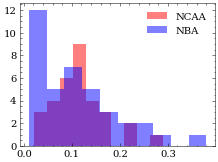

In [3]:
plt.style.reload_library()
plt.style.use('science')
plt.style.use(['science','no-latex'])

all_chalk_indexes = [541, 372, 213, 421, 278, 339, 261, 286, 118, 173, 150, 207, 341, 275, 238, 421, 227, 309, 264, 260, 226, 405, 55, 142, 112, 316, 595, 224, 370, 732, 179, 307]
NBA = [6, 4, 21, 7, 19, 22, 19, 5, 16, 41, 73, 7, 2, 10, 52, 6, 17, 28, 10, 30, 20, 33, 47, 2, 14, 26, 44, 30, 19, 9, 6, 3, 5, 34, 14, 29, 45, 36]
 
normalized_NCAA = [i/2528 for i in all_chalk_indexes]
normalized_NBA = [i/192 for i in NBA]

plt.hist(normalized_NCAA, label = 'NCAA', color = 'r', alpha = 0.5)
plt.hist(normalized_NBA, label = 'NBA', color = 'b', alpha = 0.5)
plt.legend()
plt.show()

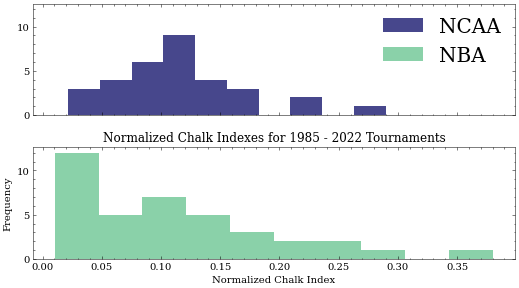

In [14]:

fig, axs = plt.subplots(2, 1, sharey=True, sharex=True, tight_layout=True)

axs[0].hist(normalized_NCAA, bins=10, label = 'NCAA', color = 'midnightblue', alpha = 0.8)
axs[1].hist(normalized_NBA, bins=10, label = 'NBA', color = 'mediumseagreen', alpha = 0.6)
fig.legend(fontsize=20) 
fig.set_size_inches(7.4, 4.2, forward=True)

plt.xlabel("Normalized Chalk Index")
plt.ylabel("Frequency")

plt.title("Normalized Chalk Indexes for 1985 - 2022 Tournaments")

fig.show()

In [ ]:
number_of_wins = dict()
for year in range(1985, 2017):
  temp = getBracket(year)
  for i in list(temp[temp['R_64']==1]['Name+Seed']):
    curr_winner = i.split()[-1]
    if curr_winner not in number_of_wins:
      number_of_wins[curr_winner] = 0
    number_of_wins[curr_winner] += 1  
number_of_wins